In [1]:
# Set JAVA_HOME explicitly
import os

os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@17"
os.environ["PATH"] = f'{os.environ["JAVA_HOME"]}/bin:' + os.environ["PATH"]

# Reference spark and spark context
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder\
    .appName("career_df")\
    .getOrCreate()
sc= spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/28 17:27:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:


# Load the dataset into a Spark Dataframe
career_df = spark.read.parquet("../Data/clean/career_df.parquet")

# Diplay the dataframe
career_df.show()
career_df.printSchema()

+--------------------+------------------+---+------+-------------------+---------------+--------------------+----------------+-----------------+-----------------+------+------------+----------------------+----------+----------------+--------------------+--------------+----------------------+-------------------+---------------------+--------------------+-------------------+---------------------------+
|      Field of Study|Current Occupation|Age|Gender|Years of Experience|Education Level|Industry Growth Rate|Job Satisfaction|Work-Life Balance|Job Opportunities|Salary|Job Security|Career Change Interest|Skills Gap|Family Influence|Mentorship Available|Certifications|Freelancing Experience|Geographic Mobility|Professional Networks|Career Change Events|Technology Adoption|Likely to Change Occupation|
+--------------------+------------------+---+------+-------------------+---------------+--------------------+----------------+-----------------+-----------------+------+------------+----------

In [0]:
career_df.printSchema()

root
 |-- Field of Study: string (nullable = true)
 |-- Current Occupation: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Years of Experience: integer (nullable = true)
 |-- Education Level: string (nullable = true)
 |-- Industry Growth Rate: string (nullable = true)
 |-- Job Satisfaction: integer (nullable = true)
 |-- Work-Life Balance: integer (nullable = true)
 |-- Job Opportunities: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Job Security: integer (nullable = true)
 |-- Career Change Interest: integer (nullable = true)
 |-- Skills Gap: integer (nullable = true)
 |-- Family Influence: string (nullable = true)
 |-- Mentorship Available: integer (nullable = true)
 |-- Certifications: integer (nullable = true)
 |-- Freelancing Experience: integer (nullable = true)
 |-- Geographic Mobility: integer (nullable = true)
 |-- Professional Networks: integer (nullable = true)
 |-- Career Change Events: integer

In [ ]:
# Encode the categorical columns
from pyspark.ml.feature import StringIndexer

categorical_columns = [
    "Field of Study", "Current Occupation", "Gender",
    "Education Level", "Industry Growth Rate", "Family Influence"
]

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_columns]

# Apply indexers
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers)
career_df_indexed = pipeline.fit(career_df).transform(career_df)


In [ ]:
# Assemble feature vectors
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "Field of Study_Index", "Current Occupation_Index", "Gender_Index",
    "Education Level_Index", "Industry Growth Rate_Index", "Family Influence_Index",
    "Age", "Years of Experience", "Job Satisfaction", "Work-Life Balance",
    "Job Opportunities", "Salary", "Job Security", "Career Change Interest",
    "Skills Gap", "Mentorship Available", "Certifications", "Freelancing Experience",
    "Geographic Mobility", "Professional Networks", "Career Change Events",
    "Technology Adoption"
]

# Create a VectorAssembler to combine the indexed columns into a single feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the DataFrame to include the feature vector
career_df_vectorized = assembler.transform(career_df_indexed)

In [14]:
# Create the model
from pyspark.sql.functions import col
model_data = career_df_vectorized.select("features", col("Likely to Change Occupation").alias("label"))

# Split the data into training and testing sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

# Print the number of rows in each set
print(f"Training rows: {train.count()}, Testing rows: {test.count()}")

Training rows: 30769, Testing rows: 7675


In [16]:
# Save the training and testing data as Parquet files
train.write.mode("overwrite").parquet("../Data/career_train_data.parquet")
test.write.mode("overwrite").parquet("../Data/career_test_data.parquet")


In [17]:
# Train the model using the logistic regression algorithm
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")

lr_model = lr.fit(train)

25/07/24 16:52:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [ ]:
# Make predictions on the test data
predictions = lr_model.transform(test)
predictions.show()

# Save the prediction results to Parquet
predictions.write.mode("overwrite").save("../Data/career_predictions.parquet")


# Save to CSV for Power BI
predictions.toPandas().to_csv("../Data/career_predictions.csv", index=False)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(22,[0,1,2,3,6,8,...|    0|[5.04106893564974...|[0.99357471921621...|       0.0|
|(22,[0,1,2,4,6,8,...|    1|[-0.4341873201244...|[0.39312688272977...|       1.0|
|(22,[0,1,2,5,6,8,...|    0|[5.85941966499008...|[0.99715521703857...|       0.0|
|(22,[0,1,2,6,7,8,...|    0|[5.22555565620782...|[0.99465139029960...|       0.0|
|(22,[0,1,2,6,7,8,...|    0|[2.00615737725759...|[0.88144204878477...|       0.0|
|(22,[0,1,2,6,7,8,...|    0|[4.55917529557175...|[0.98963780869066...|       0.0|
|(22,[0,1,2,6,7,8,...|    1|[-3.0707238358057...|[0.04433115151688...|       1.0|
|(22,[0,1,2,6,7,8,...|    0|[2.14513906700345...|[0.89521366664543...|       0.0|
|(22,[0,1,3,5,6,8,...|    0|[0.99452256075309...|[0.72998028671008...|       0.0|
|(22,[0,1,3,5,6,

In [ ]:
# Filter predictions for Power BI
from pyspark.sql.functions import col
predictions_bi = predictions.filter(col("prediction")==1)

# Save predictions to CSV
predictions_bi.toPandas().to_csv("../Data/bi_career_predictions.csv", index=False)

25/07/25 15:25:53 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 536366 ms exceeds timeout 120000 ms
25/07/25 15:25:53 WARN SparkContext: Killing executors is not supported by current scheduler.
25/07/25 15:37:16 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [20]:
# Evaluate the model's performance using the area under the ROC curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

AUC: 0.8945


In [21]:
# Evaluate the model's performance using the accuracy metric
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

Accuracy: 0.8969
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0| 2853|
|    0|       1.0|  395|
|    1|       0.0|  396|
|    1|       1.0| 4031|
+-----+----------+-----+



In [22]:
# coefficients and intercept
coefficients=lr_model.coefficients
intercepts=lr_model.intercept
print(coefficients)
print(intercepts)

[-0.01303938543089675,-0.00047719559212591696,0.04705943852762971,0.014641444243808664,0.04196858863405187,-0.03594927614239144,-0.0022058245443229807,0.0005549698577861001,-1.1412939276882272,-0.010350565375043278,0.0003270835905629703,-2.59766029079196e-05,-0.003100103678962818,27.203396224190357,0.0011835863976652195,-0.025994239262693754,-0.02048750387239681,0.10817890385433769,-0.028094411990814652,0.002708884643302217,0.03651583053616933,0.004161393658319983]
9.009885786378405


In [23]:
# List each feature with their respective coefficient
for name, coef in zip(feature_cols, coefficients):
    print(f"{name}: {coef:.4f}")

Field of Study_Index: -0.0130
Current Occupation_Index: -0.0005
Gender_Index: 0.0471
Education Level_Index: 0.0146
Industry Growth Rate_Index: 0.0420
Family Influence_Index: -0.0359
Age: -0.0022
Years of Experience: 0.0006
Job Satisfaction: -1.1413
Work-Life Balance: -0.0104
Job Opportunities: 0.0003
Salary: -0.0000
Job Security: -0.0031
Career Change Interest: 27.2034
Skills Gap: 0.0012
Mentorship Available: -0.0260
Certifications: -0.0205
Freelancing Experience: 0.1082
Geographic Mobility: -0.0281
Professional Networks: 0.0027
Career Change Events: 0.0365
Technology Adoption: 0.0042


                       Feature  Coefficient
13      Career Change Interest    27.203396
8             Job Satisfaction    -1.141294
17      Freelancing Experience     0.108179
2                 Gender_Index     0.047059
4   Industry Growth Rate_Index     0.041969
20        Career Change Events     0.036516
5       Family Influence_Index    -0.035949
18         Geographic Mobility    -0.028094
15        Mentorship Available    -0.025994
16              Certifications    -0.020488
3        Education Level_Index     0.014641
0         Field of Study_Index    -0.013039
9            Work-Life Balance    -0.010351
21         Technology Adoption     0.004161
12                Job Security    -0.003100
19       Professional Networks     0.002709
6                          Age    -0.002206
14                  Skills Gap     0.001184
7          Years of Experience     0.000555
1     Current Occupation_Index    -0.000477
10           Job Opportunities     0.000327
11                      Salary  

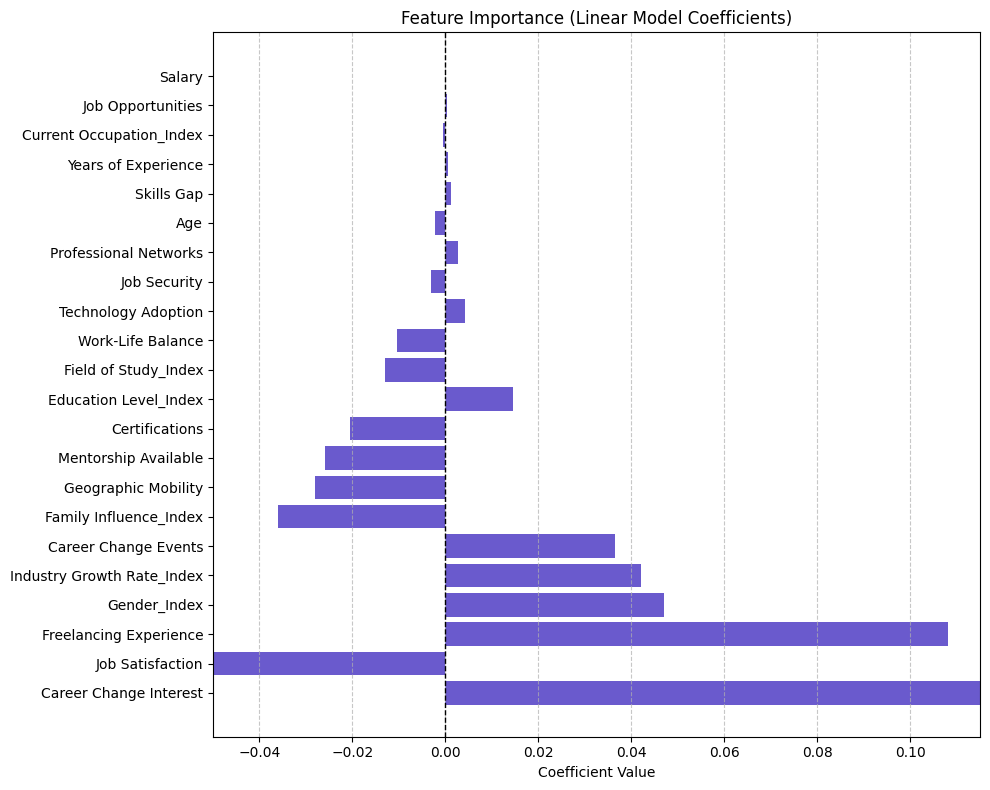

In [34]:
import pandas as pd

# Get coefficients from the model and convert to list
coefs = lr_model.coefficients.toArray().tolist()

# Create a pandas DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": coefs
}).sort_values("Coefficient", key=abs, ascending=False)

# Display the DataFrame in notebook (optional)
print(coef_df)

import matplotlib.pyplot as plt

# Sort features by absolute coefficient value (already done)
coef_df_sorted = coef_df.copy()

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(
    y=coef_df_sorted["Feature"],
    width=coef_df_sorted["Coefficient"],
    color='slateblue'
)

# Add vertical line at 0 for visual reference
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

# X-axis limit from -0.05 to 0.05
plt.xlim(-0.05, .115)

# Labels and title
plt.xlabel("Coefficient Value")
plt.title("Feature Importance (Linear Model Coefficients)")
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [27]:
# save the model
lr_model.write().overwrite().save("../career_prediction_model")